In [1]:
import os
import sys
sys.path.append('..')

In [2]:
import re
import codecs

import numpy as np
import pandas as pd
import mpld3
import nltk
from nltk.stem.snowball import SnowballStemmer

from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans
from sklearn import feature_extraction
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib as mpl
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from preprocessing import get_dataframe, set_seed

In [3]:
set_seed(42)

In [4]:
df = get_dataframe(os.path.join('..', 'data', 'lyrics'))
df

,album,song,text
0,AHardDaysNight,Ill_Be_Back.txt,"You know, if you break my heart I'll go But I'..."
1,AHardDaysNight,Cant_Buy_Me_Love.txt,"Can't buy me love, oh Love, oh Can't buy me lo..."
2,AHardDaysNight,Any_Time_At_All.txt,Any time at all Any time at all Any time at al...
3,AHardDaysNight,A_Hard_Days_Night.txt,It's been a hard day's night And I've been wor...
4,AHardDaysNight,Ill_Cry_Instead.txt,I've got every reason on earth to be mad 'Caus...
...,...,...,...
177,Help,Another_Girl.txt,For I have got another girl Another girl You'...
178,Help,Help.txt,Help! I need somebody Help! Not just anybody H...
179,Help,Ive_Just_Seen_A_Face.txt,I've just seen a face I can't forget the time ...
180,Help,Tell_Me_What_You_See.txt,If you let me take your heart I will prove to ...


In [5]:
# remove duplicated songs from df - see basic_EDA.ipynb for detailed description
df.drop(df[(df.song == "All_You_Need_Is_Love.txt") & (df.album == "YellowSubmarine")].index, inplace=True)
df.drop(df[(df.song == "Yellow_Submarine.txt") & (df.album == "YellowSubmarine")].index, inplace=True)

In [6]:
df

,album,song,text
0,AHardDaysNight,Ill_Be_Back.txt,"You know, if you break my heart I'll go But I'..."
1,AHardDaysNight,Cant_Buy_Me_Love.txt,"Can't buy me love, oh Love, oh Can't buy me lo..."
2,AHardDaysNight,Any_Time_At_All.txt,Any time at all Any time at all Any time at al...
3,AHardDaysNight,A_Hard_Days_Night.txt,It's been a hard day's night And I've been wor...
4,AHardDaysNight,Ill_Cry_Instead.txt,I've got every reason on earth to be mad 'Caus...
...,...,...,...
177,Help,Another_Girl.txt,For I have got another girl Another girl You'...
178,Help,Help.txt,Help! I need somebody Help! Not just anybody H...
179,Help,Ive_Just_Seen_A_Face.txt,I've just seen a face I can't forget the time ...
180,Help,Tell_Me_What_You_See.txt,If you let me take your heart I will prove to ...


In [7]:
def word_cloud(texts, title=''):
    text = ' '.join(texts)
    wordcloud = WordCloud().generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    
def assign_clusters(df, clusters):
    df_clust = df.copy()
    df_clust['cluster'] = clusters
    word_cloud(df_clust.text, title='WordCloud: All Songs')
    for cluster in df_clust.cluster.unique():
        songs = list(df_clust[df_clust.cluster == cluster].song)
        songs = [s.replace('.txt', '') for s in songs]
        print(f'Cluster {cluster} has {len(songs)} unique songs:\n{", ".join(songs)}\n')
        word_cloud(df_clust[df_clust.cluster == cluster]['text'], title=f'WordCloud: Cluster #{cluster}')

    return df_clust

#### Approach 1: use DistilBert for word embeddings, then K-Means with k=3 for clustering

In [8]:
embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

corpus = list(df.text)

corpus_embeddings = embedder.encode(corpus)

num_clusters = 3
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

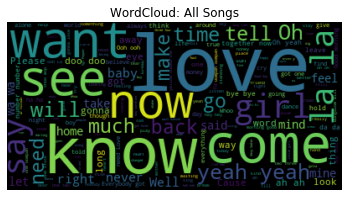

Cluster 0 has 65 unique songs:
Ill_Be_Back, Any_Time_At_All, A_Hard_Days_Night, Ill_Cry_Instead, You_Cant_Do_That, When_I_Get_Home, Tell_Me_Why, I_Want_You_Shes_So_Heavy, Because, Here_Comes_The_Sun, Oh_Darling, Ive_Got_A_Feeling, I_Me_Mine, One_After_909, The_Long_And_Winding_Road, Please_Please_Me, Theres_A_Place, I_Saw_Her_Standing_There, Misery, I_Want_To_Tell_You, For_No_One, Im_Only_Sleeping, Tomorrow_Never_Knows, She_Said_She_Said, Got_To_Get_You_Into_My_Life, And_Your_Bird_Can_Sing, The_Fool_On_The_Hill, Blue_Jay_Way, I_Dont_Want_To_Spoil_The_Party, Im_A_Loser, Babys_In_Black, What_Youre_Doing, No_Reply, Ill_Follow_The_Sun, Think_For_Yourself, Girl, Run_For_Your_Life, Im_Looking_Through_You, Nowhere_Man, What_Goes_On, Wait, You_Wont_See_Me, Dont_Bother_Me, Little_Child, Not_A_Second_Time, Good_Morning_Good_Morning, With_A_Little_Help_From_My_Friends, Fixing_A_Hole, Dont_Pass_Me_By, Blackbird, Yer_Blues, While_My_Guitar_Gently_Weeps, Revolution_1, Im_So_Tired, Why_Dont_We_Do_It_

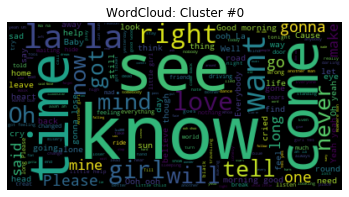

Cluster 2 has 51 unique songs:
Cant_Buy_Me_Love, If_I_Fell, I_Should_Have_Known_Better, Im_Happy_Just_To_Dance_With_You, Things_We_Said_Today, And_I_Love_Her, The_End, Golden_Slumbers, Something, Her_Majesty, For_You_Blue, Ask_Me_Why, Love_Me_Do, Anna_(Go_To_Him), Baby_Its_You, A_Taste_Of_Honey, Chains, PS_I_Love_You, Do_You_Want_To_Know_A_Secret, Love_You_To, Here_There_And_Everywhere, Good_Day_Sunshine, All_You_Need_Is_Love, Eight_Days_A_Week, Every_Little_Thing, Words_Of_Love, Mr_Moonlight, Honey_Dont, If_I_Needed_Someone, Drive_My_Car, In_My_Life, The_Word, Michelle, Hold_Me_Tight, All_Ive_Got_To_Do, Money_(Thats_What_I_Want), It_Wont_Be_Long, You_Really_Got_A_Hold_On_Me, Till_There_Was_You, I_Wanna_Be_Your_Man, All_My_Loving, Devil_In_Her_Heart, Within_You_WIthout_You, I_Will, Good_Night, Julia, Long_Long_Long, Its_All_Too_Much, The_Night_Before, I_Need_You, Its_Only_Love



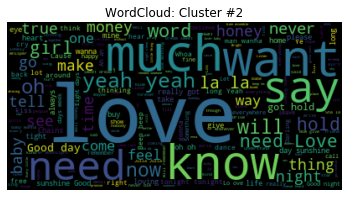

Cluster 1 has 64 unique songs:
Sun_King, Maxwells_Silver_Hammer, Octopuss_Garden, Carry_That_Weight, You_Never_Give_Me_Your_Money, Mean_Mr_Mustard, Come_Together, She_Came_In_Through_The_Bathroom_Window, Polythene_Pam, Dig_It, Two_Of_Us, Maggie_Mae, Get_Back, Dig_A_Pony, Across_The_Universe, Twist_And_Shout, Boys, Doctor_Robert, Eleanor_Rigby, Taxman, Yellow_Submarine, Penny_Lane, Baby_Youre_A_Rich_Man, Your_Mother_Should_Know, I_Am_The_Walrus, Magical_Mystery_Tour, Rock_And_Roll_Music, Kansas_City_Hey_Hey_Hey_Hey, Everybodys_Trying_To_Be_My_Baby, Norwegian_Wood_(This_Bird_Has_Flown), Roll_Over_Beethoven, Please_Mr_Postman, Sgt_Peppers, Lucy_In_The_Sky_With_Diamonds, Lovely_Rita, Getting_Better, Sgt_Peppers_Reprise, When_Im_Sixty_Four, A_Day_In_The_Life, Being_For_The_Benefit_Of_Mr_Kite, Shes_Leaving_Home, Piggies, Dear_Prudence, Back_In_The_USSR, Helter_Skelter, Martha_My_Dear, Wild_Honey_Pie, Savoy_Truffle, Ob_La_Di_Ob_La_Da, Revolution_9, Rocky_Raccoon, Happiness_Is_A_Warm_Gun, Hone

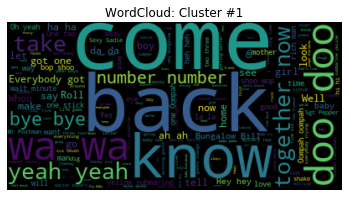

In [9]:
df_clust = assign_clusters(df, cluster_assignment)

#### Approach 2: NLTK cleaning text, then tf-idf for vectoriation, KMEans for clustering

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

In [11]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [12]:
tokenize_and_stem("I'll can't we'll shouldn't")

['i', 'll', 'ca', "n't", 'we', 'll', 'should', "n't"]

In [13]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in df.text:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [14]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 36490 items in vocab_frame


In [15]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(df.text) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

/Users/nazariinyzhnyk/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(180, 22)


In [16]:
terms = tfidf_vectorizer.get_feature_names()

In [17]:
dist = 1 - cosine_similarity(tfidf_matrix)

In [18]:
num_clusters = 3

km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

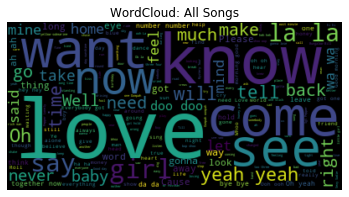

Cluster 0 has 98 unique songs:
Ill_Be_Back, Any_Time_At_All, Ill_Cry_Instead, You_Cant_Do_That, When_I_Get_Home, Im_Happy_Just_To_Dance_With_You, Tell_Me_Why, Oh_Darling, Carry_That_Weight, You_Never_Give_Me_Your_Money, Golden_Slumbers, Something, Come_Together, She_Came_In_Through_The_Bathroom_Window, Polythene_Pam, Her_Majesty, Dig_It, Ive_Got_A_Feeling, Maggie_Mae, Get_Back, The_Long_And_Winding_Road, Dig_A_Pony, Twist_And_Shout, Please_Please_Me, Boys, A_Taste_Of_Honey, Misery, I_Want_To_Tell_You, Im_Only_Sleeping, Doctor_Robert, She_Said_She_Said, Eleanor_Rigby, Good_Day_Sunshine, Got_To_Get_You_Into_My_Life, Taxman, Yellow_Submarine, And_Your_Bird_Can_Sing, The_Fool_On_The_Hill, Blue_Jay_Way, Baby_Youre_A_Rich_Man, Your_Mother_Should_Know, I_Dont_Want_To_Spoil_The_Party, Im_A_Loser, Babys_In_Black, Every_Little_Thing, Kansas_City_Hey_Hey_Hey_Hey, Honey_Dont, No_Reply, Ill_Follow_The_Sun, Think_For_Yourself, Drive_My_Car, Girl, Norwegian_Wood_(This_Bird_Has_Flown), Run_For_Your_Li

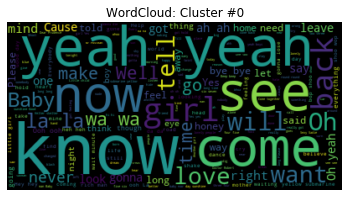

Cluster 1 has 41 unique songs:
Cant_Buy_Me_Love, If_I_Fell, I_Should_Have_Known_Better, Things_We_Said_Today, And_I_Love_Her, Because, The_End, For_You_Blue, Ask_Me_Why, Love_Me_Do, Anna_(Go_To_Him), Chains, PS_I_Love_You, I_Saw_Her_Standing_There, Do_You_Want_To_Know_A_Secret, For_No_One, Tomorrow_Never_Knows, Love_You_To, Here_There_And_Everywhere, All_You_Need_Is_Love, Eight_Days_A_Week, Words_Of_Love, Mr_Moonlight, If_I_Needed_Someone, In_My_Life, The_Word, Michelle, Hold_Me_Tight, Till_There_Was_You, I_Wanna_Be_Your_Man, All_My_Loving, Lovely_Rita, With_A_Little_Help_From_My_Friends, Within_You_WIthout_You, Wild_Honey_Pie, I_Will, Julia, Long_Long_Long, All_Together_Now, Youve_Got_To_Hide_Your_Love_Away, Its_Only_Love



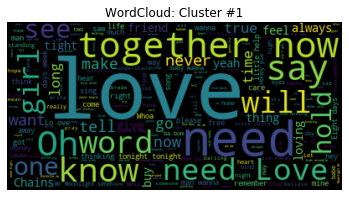

Cluster 2 has 41 unique songs:
A_Hard_Days_Night, I_Want_You_Shes_So_Heavy, Sun_King, Maxwells_Silver_Hammer, Octopuss_Garden, Here_Comes_The_Sun, Mean_Mr_Mustard, I_Me_Mine, One_After_909, Two_Of_Us, Across_The_Universe, Baby_Its_You, Theres_A_Place, Penny_Lane, I_Am_The_Walrus, Magical_Mystery_Tour, Rock_And_Roll_Music, What_Youre_Doing, Everybodys_Trying_To_Be_My_Baby, Money_(Thats_What_I_Want), Devil_In_Her_Heart, Roll_Over_Beethoven, Sgt_Peppers, Good_Morning_Good_Morning, Getting_Better, Sgt_Peppers_Reprise, Shes_Leaving_Home, Piggies, Ob_La_Di_Ob_La_Da, Revolution_9, Rocky_Raccoon, The_Continuing_Story_Of_Bulgalow_Bill, Good_Night, Mother_Nautres_Son, Birthday, Everybodys_Got_Something_To_Hide_Excpet_For_Me_And_My_Monkey, Cry_Baby_Cry, Only_A_Northern_Song, Its_All_Too_Much, Hey_Bulldog, Ticket_To_Ride



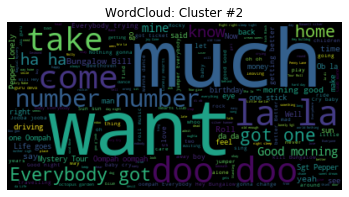

In [19]:
df_clust = assign_clusters(df, clusters)

In [20]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

In [21]:
cluster_words = []
for i in range(num_clusters):
    curr_cluster = []
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
        curr_cluster.append(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])
    cluster_words.append(curr_cluster)
    print()

Cluster 0 words: n't, 'm, yeah, 'll, know, oh, 's, girl, come, time,
Cluster 1 words: love, 'll, know, say, n't, 's, oh, tells, 'm, day,
Cluster 2 words: 's, got, come, like, say, n't, time, yeah, know, wants,


In [22]:
MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [23]:
cluster_names = {i: ' | '.join(cluster_words[i]) for i in range(len(cluster_words))}

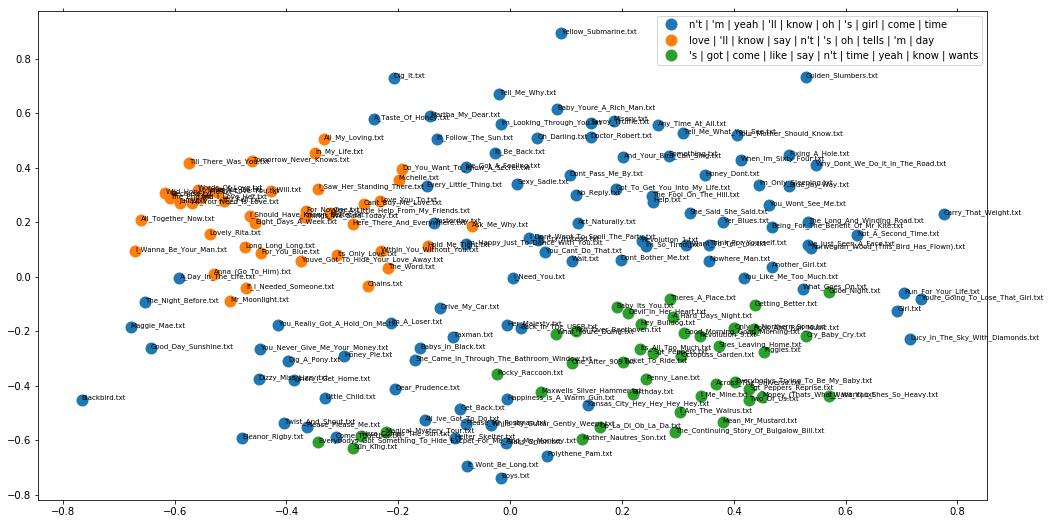

In [24]:
df_plot = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=df.song)) 

#group by cluster
groups = df_plot.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x', which='both',bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df_plot)):
    ax.text(list(df_plot.x)[i], list(df_plot.y)[i], list(df_plot.title)[i], size=7)  

plt.show() 

#### As one can see, here is one certain 'love' cluster, where most of the love songs (like All_You_Need_Is_Love, Cant_Buy_Me_Love, And_I_Love_Her) are located. There is also cluster that contain mostly 'got', 'come', 'like', 'say' words with songs Penny Lane, Birthday, Rocky_Raccoon. And the final cluster contains all the rest words; on the plot above it's very sparse: not so concentrated along as other clusters. All the clusters' top-words contain words like "'s", "'ll", "n't", "come", "know".

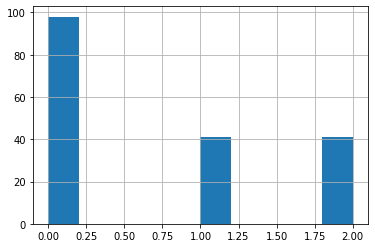

In [25]:
df_clust.cluster.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fc7d33790>,
      dtype=object)

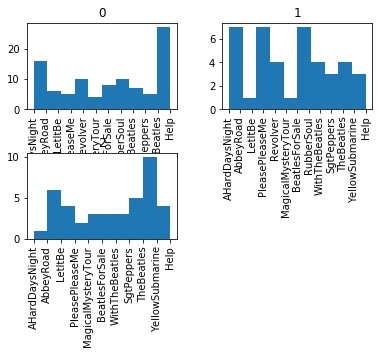

In [26]:
df_clust.album.hist(by=df_clust['cluster'])

#### When clustering into 2 clusters, there will be separate cluster for 'love songs' and separate for others